#                                Browser fingerprint analysis 

## Importing of necessary librairies

In [4]:
import MySQLdb as mdb
import numpy as np
import csv
import sys
import re
sys.path.append("../src/")
from src.fingerprint import Fingerprint
from src import CSV_DELIMITER
from src.analyse import compute_normalized_entropy

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

DATA_PATH_REL = "../../data/"

#Matplotlib figures inserted into the notebook
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Read the file

In [5]:
# Exclusion of some attributes
ATTRIBUTES_TO_EXCLUDE = [Fingerprint.COUNTER, Fingerprint.CREATION_TIME, Fingerprint.END_TIME, Fingerprint.CONSISTENT]

In [6]:
# read the file
df = pd.read_csv(DATA_PATH_REL + "processed/fingerprint_dataset.csv", delimiter=CSV_DELIMITER, engine="python")

## Visualization of consistent fingerprints

In [7]:
# Analysis of consistent fingerprints
attributes_to_analyze = [attribute for attribute in df.columns.tolist() if attribute not in ATTRIBUTES_TO_EXCLUDE]
df_consistent = df[df[Fingerprint.CONSISTENT] == True ]
print("There are {:d} elements in df_consistent".format(len(df_consistent)))

There are 49271 elements in df_consistent


In [7]:
# Name of attributes
print(df_consistent.columns, "There are {:d} columns in df_consistent".format(len(df_consistent.columns)))

Index(['counter', 'id', 'creationDate', 'endDate', 'addressHttp',
       'userAgentHttp', 'acceptHttp', 'connectionHttp', 'encodingHttp',
       'languageHttp', 'orderHttp', 'pluginsJSHashed', 'platformJS',
       'cookiesJS', 'dntJS', 'timezoneJS', 'resolutionJS', 'localJS',
       'sessionJS', 'canvasJSHashed', 'fontsFlashHashed', 'resolutionFlash',
       'languageFlash', 'platformFlash', 'browserFamily',
       'globalBrowserVersion', 'minorBrowserVersion', 'majorBrowserVersion',
       'os', 'rendererWebGLJS', 'vendorWebGLJS', 'pluginsJS', 'consistent'],
      dtype='object') There are 33 columns in df_consistent


In [8]:
# Visualization of the first 5 lines
df_consistent.head(5)

,counter,id,creationDate,endDate,addressHttp,userAgentHttp,acceptHttp,connectionHttp,encodingHttp,languageHttp,...,platformFlash,browserFamily,globalBrowserVersion,minorBrowserVersion,majorBrowserVersion,os,rendererWebGLJS,vendorWebGLJS,pluginsJS,consistent
15,17,0f4f77e3-80da-4b4a-b9c0-f5e8c4239380,2015-07-27 11:00:00,None,24f5398bba446ce8dadfd3d23ca2f4e58895e76e,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","en-US,en;q=0.8,fr;q=0.6",...,Linux,Chrome,440,0,44,Linux,Mesa DRI Intel(R) Haswell Mobile,Intel Open Source Technology Center,Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...,True
17,19,74bf8f6f-0114-44b4-9bca-1cfc52ffc2d3,2015-07-27 12:00:00,None,24f5398bba446ce8dadfd3d23ca2f4e58895e76e,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","en-US,en;q=0.8,fr;q=0.6",...,Linux,Chrome,440,0,44,Linux,Mesa DRI Intel(R) Haswell Mobile,Intel Open Source Technology Center,Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...,True
18,20,df46c5fb-9889-4ff4-9f51-e5af591f3460,2015-07-27 12:00:00,None,24f5398bba446ce8dadfd3d23ca2f4e58895e76e,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","en-US,en;q=0.8,fr;q=0.6",...,Linux,Chrome,440,0,44,Linux,Mesa DRI Intel(R) Haswell Mobile,Intel Open Source Technology Center,Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...,True
19,21,dc031028-a4ea-4ce8-a362-17b07a4f4d65,2015-07-27 12:00:00,2015-07-28 11:00:00,90f2974eff1d1b3f05d01f413cf0241fae23352e,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_4...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","fr-FR,fr;q=0.8,en-US;q=0.6,en;q=0.4",...,Mac OS 10.10.4,Chrome,440,0,44,Mac OS X,Intel HD Graphics 5000 OpenGL Engine,Intel Inc.,Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...,True
20,22,d51d09c6-2596-4958-bfe7-0352af2aaccf,2015-07-27 12:00:00,2015-07-29 06:00:00,2515ee56512877237d467911f5c55be53eea3550,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, sdch","fr-FR,fr;q=0.8,en-US;q=0.6,en;q=0.4",...,Linux,Chrome,430,0,43,Linux,Not supported,Not supported,Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...,True


In [117]:
print("Statistics on dataset filtered: only consistent browsers")
for attribute in attributes_to_analyze:
    nb_distinct_values = df_consistent[attribute].value_counts().count()
    print("{} : {:d} distinct values".format(attribute, nb_distinct_values))

Statistics on dataset filtered: only consistent browsers
id : 4651 distinct values
addressHttp : 15781 distinct values
userAgentHttp : 2289 distinct values
acceptHttp : 7 distinct values
connectionHttp : 1 distinct values
encodingHttp : 12 distinct values
languageHttp : 424 distinct values
orderHttp : 114 distinct values
pluginsJSHashed : 4247 distinct values
platformJS : 17 distinct values
cookiesJS : 2 distinct values
dntJS : 2 distinct values
timezoneJS : 33 distinct values
resolutionJS : 446 distinct values
localJS : 2 distinct values
sessionJS : 2 distinct values
canvasJSHashed : 938 distinct values
fontsFlashHashed : 4684 distinct values
resolutionFlash : 257 distinct values
languageFlash : 27 distinct values
platformFlash : 222 distinct values
browserFamily : 18 distinct values
globalBrowserVersion : 78 distinct values
minorBrowserVersion : 21 distinct values
majorBrowserVersion : 43 distinct values
os : 14 distinct values
rendererWebGLJS : 489 distinct values
vendorWebGLJS : 13

## Descriptive analysis of consistent fingerprints

In [15]:
def display_entropy(df, attributes):
    data_df = []
    for attribute in attributes:
        data_df.append({
            "Attribute": attribute,
            "Relative entropy": compute_normalized_entropy(df, attribute)
        })

    entropy_df = pd.DataFrame(data_df).sort_values(by="Relative entropy", ascending=False).reset_index(drop=True)
    display(HTML(entropy_df.to_html()))

attributes = [attribute for attribute in attributes_to_analyze if attribute != "id"]
display_entropy(df_consistent, attributes_to_analyze)

,Attribute,Relative entropy
0,addressHttp,0.888301
1,userAgentHttp,0.613847
2,pluginsJSHashed,0.610079
3,fontsFlashHashed,0.542996
4,canvasJSHashed,0.487428
5,languageHttp,0.320505
6,resolutionJS,0.289189
7,globalBrowserVersion,0.269478
8,rendererWebGLJS,0.266548
9,majorBrowserVersion,0.264609


In [153]:
# terms : effective, %
# number of unique terms
# most common terms
def terms_analysis(df, attribute):
    tmp_stats = []
    ids = set(df['id'].unique())
    for user_id in ids:
        df_user_id = df[df_consistent['id'] == user_id]
        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                attribute : value
            })
    df_stats = pd.DataFrame(tmp_stats)
    
    nb = df_stats[attribute].value_counts()
    df_nb = pd.DataFrame(nb)
    
    nb_percent = nb/nb.sum()*100
    df_nb_percent = pd.DataFrame(nb_percent)
    
    tab = df_nb.join(df_nb_percent, lsuffix='_left', rsuffix='_right')
    tab.columns = ['effective', '%']
    
    
    print(tab)
    print()
    
    df_nb[:20].plot(kind='barh', stacked=False, width=0.9)
    plt.gca().invert_yaxis() 
    plt.grid(axis='x', linestyle = 'dashed')
    plt.title('The 20 first {}'.format(attribute))
    plt.xlabel('effective')
    plt.ylabel(attribute)
    plt.show()
    
    print("There are {:d} unique terms for the attribute '{}'".format(len(nb[nb.values == 1]), attribute))
    print()
    print("The most used terms are: \n{}".format(nb[:5]))

                                     effective          %
Not supported                             2807  57.757202
Google Inc.                               1254  25.802469
Intel Open Source Technology Center        240   4.938272
Intel Inc.                                 224   4.609053
NVIDIA Corporation                         128   2.633745
ATI Technologies Inc.                       70   1.440329
TransGaming Inc.                            50   1.028807
X.Org                                       30   0.617284
nouveau                                     21   0.432099
VMware, Inc.                                17   0.349794
Intel                                       11   0.226337
ARM                                          5   0.102881
Apple Inc.                                   3   0.061728



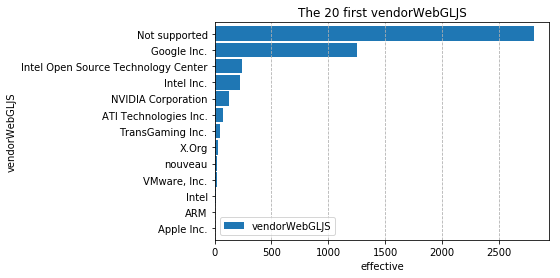

There are 0 unique terms for the attribute 'vendorWebGLJS'

The most used terms are: 
Not supported                          2807
Google Inc.                            1254
Intel Open Source Technology Center     240
Intel Inc.                              224
NVIDIA Corporation                      128
Name: vendorWebGLJS, dtype: int64


In [154]:
terms_analysis(df_consistent, 'vendorWebGLJS')

The distinct values for the attribute 'languageHttp' are : 
 ['de' 'pt' 'ru' 'en' 'fr' 'cs' 'da' 'it' 'nl' 'sv' 'sl' 'es' 'nb' 'hu'
 'pl' 'sh' 'ja' 'ac' 'uk' 'zh' 'tr' 'az' 'sk' 'fi' 'ko' 'th' 'vi' 'hr'
 'ro' 'an' 'ch' 'ca' 'ar' 'lt' 'el' 'af' 'bg' 'et']

    effective          %
en       2672  53.968895
ru        850  17.168249
fr        583  11.775399
de        320   6.463341
es         79   1.595637
it         61   1.232074
pl         59   1.191678
zh         57   1.151283
nl         52   1.050293
pt         42   0.848313
hu         35   0.706928
cs         21   0.424157
ja         18   0.363563
uk         13   0.262573
da         12   0.242375
tr          8   0.161584
ac          8   0.161584
sv          8   0.161584
fi          6   0.121188
vi          6   0.121188
ko          5   0.100990
sk          5   0.100990
af          4   0.080792
hr          4   0.080792
lt          3   0.060594
sl          3   0.060594
el          2   0.040396
nb          2   0.040396
sh          2   0.0

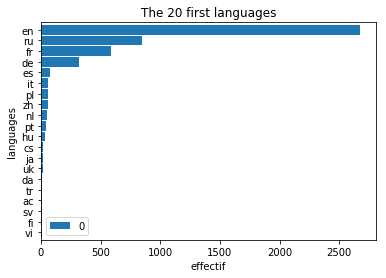

There are 7 unique terms for the attribute 'languageHttp'

The most used terms are: 
en    2672
ru     850
fr     583
de     320
es      79
Name: 0, dtype: int64


In [10]:
# terms analysis for the attribute 'languageHttp'
tmp_stats = []
ids = set(df_consistent['id'].unique())
for user_id in ids:
    df_user_id = df_consistent[df_consistent['id'] == user_id]
    different_values = df_user_id['languageHttp'].unique()
    for value in different_values:
        tmp_stats.append({
            "id": user_id,
            'languageHttp' : value
        })
df_stats = pd.DataFrame(tmp_stats)

language_http=df_stats['languageHttp']
language_http_less_nan=language_http.dropna()
language_http_less_nan_list= language_http_less_nan.values.tolist()

languages = []
for i in range(0,len(language_http_less_nan_list)):    
    languages.append(language_http_less_nan_list[i][:2])

langues_df = pd.DataFrame(languages)

print("The distinct values for the attribute 'languageHttp' are : \n {}".format(langues_df[0].unique()))

    
nb = langues_df[0].value_counts()
df_nb = pd.DataFrame(nb)
    
nb_percent = nb/nb.sum()*100
df_nb_percent = pd.DataFrame(nb_percent)
    
tab = df_nb.join(df_nb_percent, lsuffix='_left', rsuffix='_right')
tab.columns = ['effective', '%']

print()
print(tab)
print()

df_nb[:20].plot(kind='barh', stacked=False, width=0.9)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle = 'dashed')
plt.title('The 20 first languages')
plt.xlabel('effective')
plt.ylabel('languages')
plt.show()

print("There are {:d} unique terms for the attribute 'languageHttp'".format(len(nb[nb.values == 1])))
print()
print("The most used terms are: \n{}".format(nb[:5]))


In [102]:
#modality of plugins
tmp_stats = []
plugins=re.findall("Plugin [0-9]+: ([a-zA-Z -.]+)", str(df_consistent['pluginsJS']))
plugins_df=pd.DataFrame(plugins)
plugins_df[0].unique()

array(['Chrome PDF Viewer', 'Chromium PDF Viewer',
       'Default Browser Helper', 'Shockwave Flash', 'DivX',
       'Gnome Shell Integration', 'Google Update', 'Native Client',
       'Adobe Acrobat'], dtype=object)

In [140]:
def analyse_terms_splited(df, attribute, split_function):
    tmp_dataset = []
    tmp_stats = []
    ids = set(df_consistent['id'].unique())
    for user_id in ids:
        df_user_id = df_consistent[df_consistent['id'] == user_id]
        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id
            })
            values_split = split_function(value)

            for value_tmp in values_split:
                tmp_dataset.append({
                    "id": user_id,
                    attribute: value_tmp
                })

    df_tmp = pd.DataFrame(tmp_dataset)
    df_stats = pd.DataFrame(tmp_stats)
    
    nb = df_tmp[attribute].value_counts()
    df_nb = pd.DataFrame(nb)
    
    nb_percent = nb/nb.sum()*100
    df_nb_percent = pd.DataFrame(nb_percent)
    
    tab = df_nb.join(df_nb_percent, lsuffix='_left', rsuffix='_right')
    tab.columns = ['effective', '%']
    
    
    print(tab)
    print()
    
    df_nb[:20].plot(kind='barh', stacked=False, width=0.9)
    plt.gca().invert_yaxis() 
    plt.grid(axis='x', linestyle = 'dashed')
    plt.title('The 20 first {}'.format(attribute))
    plt.xlabel('effective')
    plt.ylabel(attribute)
    plt.show()
    
    print("There are {:d} unique terms for the attribute '{}'".format(len(nb[nb.values == 1]), attribute))
    print()
    print("The most used terms are: \n{}".format(nb[:5]))
    print()
    print("There are {:d} {}".format(len(nb), attribute))
    
def split_plugins(attribute):
    return re.findall("Plugin [0-9]+: ([a-zA-Z -.]+)", str(attribute))

def split_accept_http(accept):
    return accept.split(",")

def split_encoding_http(encoding):
    return encoding.split(", ")

def split_order_http(order):
    return order.split(" ")

def split_encoding_http(encoding):
    try:
        replacement=encoding.replace(","," ")
        junction=''.join(replacement)
        disjunction=junction.split()
        return disjunction 
    except:
        return [""]
 

              effective          %
gzip               5058  31.320825
deflate            5057  31.314632
br                 3647  22.583442
sdch               2364  14.638677
lzma                  9   0.055731
identity              4   0.024769
                      3   0.018577
peerdist              1   0.006192
exi                   1   0.006192
compress              1   0.006192
xpress                1   0.006192
xz                    1   0.006192
bzip2                 1   0.006192
pack200-gzip          1   0.006192



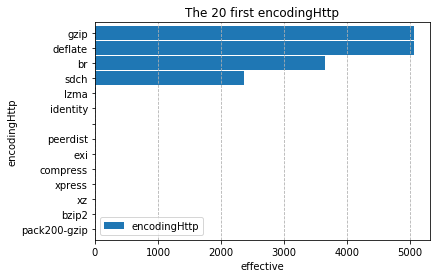

There are 7 unique terms for the attribute 'encodingHttp'

The most used terms are: 
gzip       5058
deflate    5057
br         3647
sdch       2364
lzma          9
Name: encodingHttp, dtype: int64

There are 14 encodingHttp


In [141]:
analyse_terms_splited(df_consistent, 'encodingHttp', split_encoding_http)

In [168]:
def analyze_grouped(df, attribute, group_by_attribute):
    tmp_stats = []
    ids = set(df['id'].unique())
    for user_id in ids:
        df_user_id = df[df_consistent['id'] == user_id]
        os_user = df_user_id["os"].values[0]
        browser_user = df_user_id["browserFamily"].values[0]

        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                "os": os_user,
                "browserFamily": browser_user,
                attribute: value
            })
  
    df_stats = pd.DataFrame(tmp_stats)
    stats_grouped = df_stats.groupby(group_by_attribute).size()
    grouped = df_stats.groupby([attribute])
    for name, group in grouped:
        norm = 0 
        count_per_group = group.groupby(group_by_attribute).size()
        for key, number in stats_grouped.iteritems():
            try:
                norm += abs(number - count_per_group[key])
            except KeyError:
                norm += abs(number)

        if norm >= 0:
            print(name)
            print(count_per_group)

        print(norm)

In [170]:
analyze_grouped(df_consistent,'vendorWebGLJS', 'os')

ARM
os
Chrome OS    5
dtype: int64
4855
ATI Technologies Inc.
os
Linux        5
Mac OS X    65
dtype: int64
4790
Apple Inc.
os
Mac OS X    3
dtype: int64
4857
Google Inc.
os
Windows 10       690
Windows 7        449
Windows 8         15
Windows 8.1       96
Windows Vista      3
Windows XP         1
dtype: int64
3606
Intel
os
Mac OS X    11
dtype: int64
4849
Intel Inc.
os
Mac OS X    224
dtype: int64
4636
Intel Open Source Technology Center
os
Chrome OS     65
Linux        150
Ubuntu        25
dtype: int64
4620
NVIDIA Corporation
os
Chrome OS     1
Linux        40
Mac OS X     75
Ubuntu       12
dtype: int64
4732
Not supported
os
Chrome OS          1
FreeBSD            3
Linux            288
Mac OS X         213
NetBSD             1
OpenBSD            7
Other             12
Ubuntu           260
Windows 10       578
Windows 7        984
Windows 8         42
Windows 8.1      292
Windows Vista     18
Windows XP       108
dtype: int64
2053
TransGaming Inc.
os
Windows 10       18
Windows 7  

In [163]:
def analyze_grouped_splited(df, attribute, group_by_attribute, split_function):
    tmp_dataset = []
    tmp_stats = []
    ids = set(df['id'].unique())
    for user_id in ids:
        df_user_id = df[df['id'] == user_id]
        os_user = df_user_id["os"].values[0]
        browser_user = df_user_id["browserFamily"].values[0]

        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                "os": os_user,
                "browserFamily": browser_user
            })
            values_split = split_function(value)

            for value_tmp in values_split:
                tmp_dataset.append({
                    "id": user_id,
                    "os": os_user,
                    "browserFamily": browser_user,
                    attribute: value_tmp

                })

    df_tmp = pd.DataFrame(tmp_dataset)
    df_stats = pd.DataFrame(tmp_stats)
    
    
    stats_grouped = df_stats.groupby(group_by_attribute).size()
    #print(stats_grouped)
    #stats_grouped = df_stats[group_by_attribute].value_counts()
    grouped = df_tmp.groupby([attribute])
    for name, group in grouped:
        norm = 0 
        count_per_group = group.groupby(group_by_attribute).size()
        #count_per_group = group[group_by_attribute].value_counts()
        for key, number in stats_grouped.iteritems():
            try:
                norm += (number - count_per_group[key])**2
            except KeyError:
                norm += number**2

        if norm >= 0:
            print(name)
            print(count_per_group)

        print(norm)

def split_headers(headers):
    return headers.split(" ")

def split_languages_http(languages):
    try:
        return languages.split(";")
    except AttributeError:
        return str(languages)
    
def split_accept_http(accept):
    return accept.split(",")

def split_plugins(attribute):
    return re.findall("Plugin [0-9]+: ([a-zA-Z -.]+)", str(attribute))

def split_order_http(order):
    return order.split(" ")

In [132]:
analyze_grouped_splited(df_consistent, 'orderHttp', 'browserFamily', split_order_http)

browserFamily
Chrome                         2515
Chromium                         85
Dragon                           12
Epiphany                          2
Firefox                        3207
IE Mobile                         1
Iceweasel                        34
Iron                             40
Konqueror                         1
Maxthon                           1
Opera                            16
Other                            11
Pale Moon (Firefox Variant)       2
QupZilla                          1
Rekonq                            1
SeaMonkey                         1
Vivaldi                          51
Yandex Browser                    5
dtype: int64
Accept
browserFamily
Chrome                         2515
Chromium                         85
Dragon                           12
Epiphany                          2
Firefox                        3207
IE Mobile                         1
Iceweasel                        34
Iron                             40
Konqueror       

In [165]:
analyze_grouped_splited(df_consistent, 'vendorWebGLJS', ['os', 'browserFamily'], split_plugins)

os             browserFamily              
Chrome OS      Chrome                          72
FreeBSD        Chrome                           1
               Firefox                          3
Linux          Chrome                         304
               Firefox                        177
               Iceweasel                       32
               Iron                             6
               Konqueror                        1
               Opera                            1
               QupZilla                         1
               Rekonq                           1
               Vivaldi                         14
Mac OS X       Chrome                         390
               Firefox                        191
               Iron                             1
               Opera                            2
               SeaMonkey                        1
               Vivaldi                          6
NetBSD         Firefox                          1
OpenBSD

KeyError: 'vendorWebGLJS'

In [143]:
analyse_terms_splited(df_consistent,'encodingHttp',split_function=lambda encoding: encoding.split(","))

AttributeError: 'float' object has no attribute 'split'

## Inconsistent fingerprint detection

In [48]:
# Détection of inconsistent values
df_consistent[df_consistent['browserFamily']== "IE Mobile"]["os"]

87094    Other
87096    Other
87097    Other
Name: os, dtype: object

In [49]:
# N° of the fingerprint to take off it from consistent fingerprints
df_consistent[df_consistent['browserFamily'] == "IE Mobile"]["id"]

87094    d2869d31-770a-4e4a-b91a-331c47e1e144
87096    d2869d31-770a-4e4a-b91a-331c47e1e144
87097    d2869d31-770a-4e4a-b91a-331c47e1e144
Name: id, dtype: object

In [52]:
df_consistent[df_consistent['id']== "d2869d31-770a-4e4a-b91a-331c47e1e144"]

,counter,id,creationDate,endDate,addressHttp,userAgentHttp,acceptHttp,connectionHttp,encodingHttp,languageHttp,...,platformFlash,browserFamily,globalBrowserVersion,minorBrowserVersion,majorBrowserVersion,os,rendererWebGLJS,vendorWebGLJS,pluginsJS,consistent
87094,117423,d2869d31-770a-4e4a-b91a-331c47e1e144,2017-02-10 09:00:00,2017-02-10 09:00:00,2f998c35b04d46117baa579021107c4911fd8387,safari (compatible; MSIE 9.0; samsung Phone OS...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, br","en-US,en;q=0.5",...,Flash not detected,IE Mobile,90,0,9,Other,Not supported,Not supported,NaN,True
87096,117425,d2869d31-770a-4e4a-b91a-331c47e1e144,2017-02-10 09:00:00,2017-02-10 09:00:00,2f998c35b04d46117baa579021107c4911fd8387,safari (compatible; MSIE 9.0; samsung Phone OS...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, br","en-US,en;q=0.8",...,Flash not detected,IE Mobile,90,0,9,Other,Not supported,Not supported,NaN,True
87097,117427,d2869d31-770a-4e4a-b91a-331c47e1e144,2017-02-10 09:00:00,None,2f998c35b04d46117baa579021107c4911fd8387,safari (compatible; MSIE 9.0; samsung Phone OS...,"text/html,application/xhtml+xml,application/xm...",close,"gzip, deflate, br",en-us,...,Flash not detected,IE Mobile,90,0,9,Other,Not supported,Not supported,NaN,True


In [151]:
df_consistent['vendorWebGLJS'].unique()

array(['Intel Open Source Technology Center', 'Intel Inc.',
       'Not supported', 'ATI Technologies Inc.', 'Google Inc.',
       'NVIDIA Corporation', 'TransGaming Inc.', 'X.Org', 'nouveau',
       'ARM', 'Intel', 'Apple Inc.', 'VMware, Inc.'], dtype=object)